In [1]:
import torch  # Importowanie biblioteki PyTorch
import torch.nn as nn  # Importowanie modułu do tworzenia sieci neuronowych
import torch.optim as optim  # Importowanie modułu do optymalizacji
import torchvision  # Importowanie biblioteki torchvision

# Przygotowanie transformacji danych: konwersja obrazów na tensory
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

# Wczytanie zbiorów danych CIFAR-10 do zestawów treningowych i testowych
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

batch_size = 32  # Rozmiar batcha
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

# Definicja modelu CNN
class CIFAR(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=(3, 3), stride=1, padding=1) # 3 - rgb, 23 - , wymiary ramki, o ile px przesuwamy ramke, usuwamy zewnetrzne px
        self.act1 = nn.ReLU()
        self.drop1 = nn.Dropout(0.3) # zapobiega overfittingu, pozbycie się 30% połączeń sieci

        self.conv2 = nn.Conv2d(32, 32, kernel_size=(3, 3), stride=1, padding=1)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2)) # upraszczanie obrazu, bierzemy 2x2 i wybieramy maxymalna wartość z ramki

        self.flat = nn.Flatten()

        self.fc3 = nn.Linear(8192, 512)
        self.act3 = nn.ReLU()
        self.drop3 = nn.Dropout(0.5)

        self.fc4 = nn.Linear(512, 10)

    def forward(self, x): #funkcja łącząca po kolei każdy etap uczenia
        x = self.act1(self.conv1(x))
        x = self.drop1(x)
        x = self.act2(self.conv2(x))
        x = self.pool2(x)
        x = self.flat(x)
        x = self.act3(self.fc3(x))
        x = self.drop3(x)
        x = self.fc4(x)
        return x

model = CIFAR()  # Inicjalizacja modelu
loss_fn = nn.CrossEntropyLoss()  # Wybór funkcji straty (Cross-Entropy Loss)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)  # Wybór optymalizatora (SGD)
# momentum - czasami pojawia się małe minimum tzn szukanie nowych wag się zatrzymuje, momentum pomaga wziąć większy zakres i ustalić nowy trend

n_epochs = 2  # Liczba epok treningu
for epoch in range(n_epochs):
    for inputs, labels in trainloader:
        y_pred = model(inputs)  # Przepływ danych przez model
        loss = loss_fn(y_pred, labels)  # Obliczenie funkcji straty
        optimizer.zero_grad()  # Resetowanie gradientów
        loss.backward()  # Wsteczna propagacja
        optimizer.step()  # Aktualizacja wag modelu

    acc = 0
    count = 0
    for inputs, labels in testloader:
        y_pred = model(inputs)  # Przepływ danych testowych przez model
        acc += (torch.argmax(y_pred, 1) == labels).float().sum()  # Obliczenie dokładności predykcji
        count += len(labels)
    acc /= count
    print("Epoka %d: accuracy %.2f%%" % (epoch, acc * 100))  # Wyświetlenie dokładności dla danej epoki

torch.save(model.state_dict(), "ex6_model.pth")  # Zapisanie stanu modelu


Files already downloaded and verified
Files already downloaded and verified
Epoka 0: accuracy 36.07%
Epoka 1: accuracy 40.54%


50000


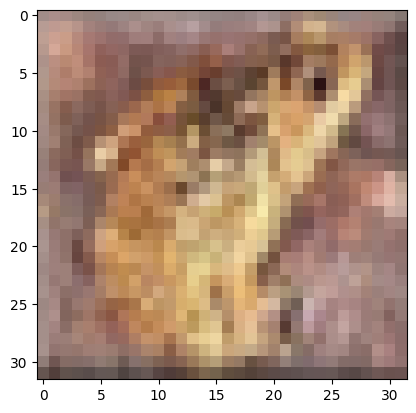

In [3]:
import matplotlib.pyplot as plt

plt.imshow(trainset.data[1237])
print(len(trainset.data))


In [4]:
# Tworzenie tensora X na podstawie danych treningowych (obrazu)
X = torch.tensor([trainset.data[7]], dtype=torch.float32).permute(0, 3, 1, 2)

# Ustawienie modelu w trybie oceny (nie oblicza gradientów)
model.eval()

# Wykonywanie predykcji bez obliczania gradientów
with torch.no_grad():
    feature_maps = model.conv1(X)
X.shape

C:\Users\smonn\AppData\Local\Temp\ipykernel_1520\3545120619.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:264.)
  X = torch.tensor([trainset.data[7]], dtype=torch.float32).permute(0, 3, 1, 2)


torch.Size([1, 3, 32, 32])

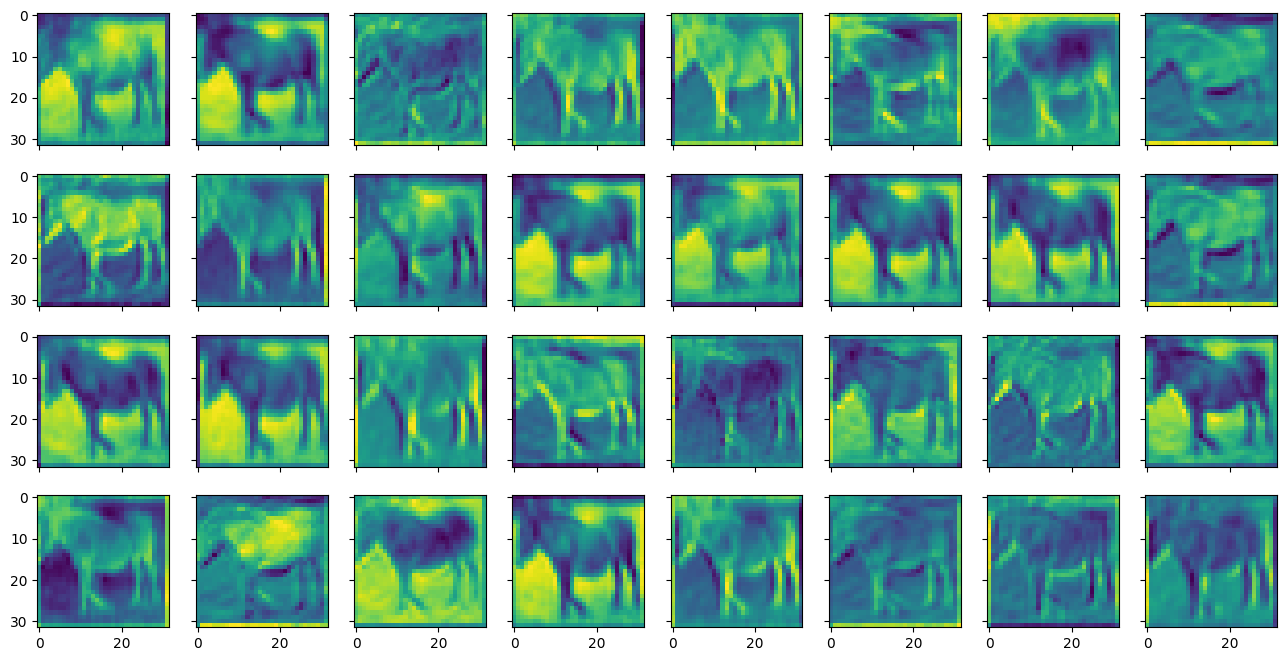

In [5]:
# Tworzenie siatki subplotów o rozmiarze 4x8 do wyświetlenia map cech
fig, ax = plt.subplots(4, 8, sharex=True, sharey=True, figsize=(16, 8))

# Pętla iterująca po mapach cech
for i in range(0, 32):
    row, col = i // 8, i % 8  # Obliczenie współrzędnych w siatce subplotów
    ax[row][col].imshow(feature_maps[0][i])  # Wyświetlenie i-tej mapy cech w subplotcie

plt.show()


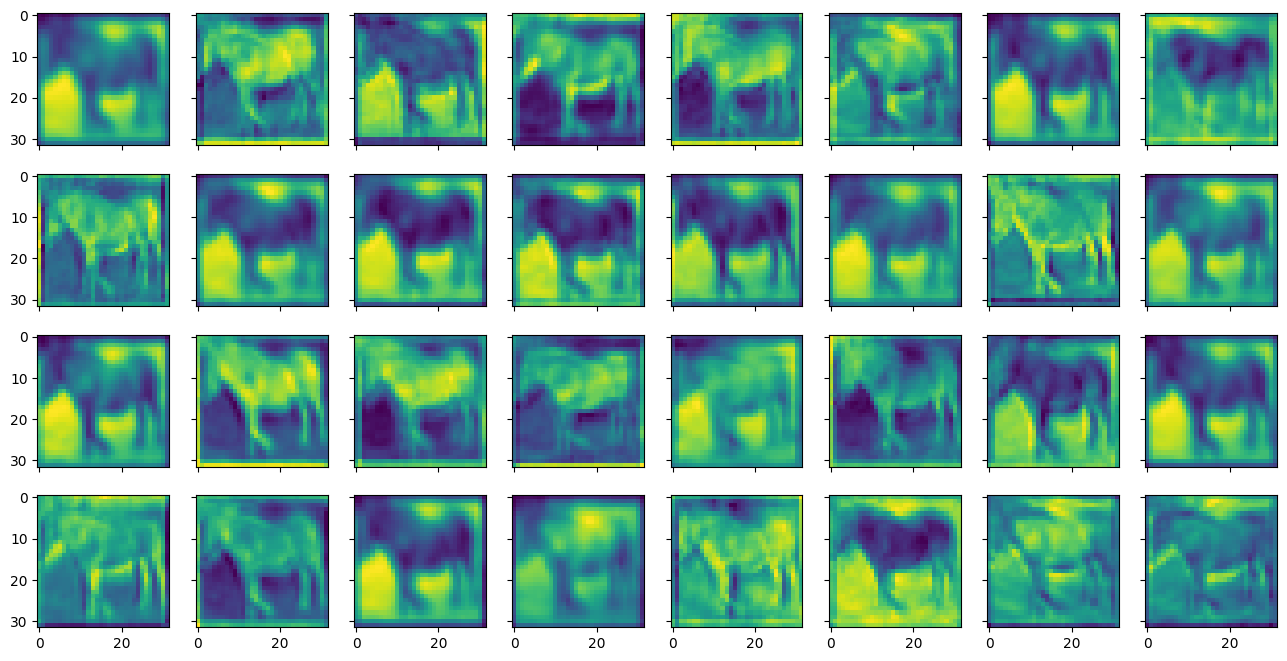

In [6]:
# Tworzenie tensora X z pierwszym obrazem treningowym, zmiana wymiarów i permutacja osi
X = torch.tensor([trainset.data[7]], dtype=torch.float32).permute(0, 3, 1, 2)

# Przełączenie modelu w tryb ewaluacji (bez trenowania)
model.eval()

# Wygenerowanie map cech dla obrazu
with torch.no_grad():
    feature_maps = model.act1(model.conv1(X))  # Obliczenie map cech po pierwszej warstwie konwolucyjnej
    feature_maps = model.drop1(feature_maps)  # Przepuszczenie przez warstwę dropout
    feature_maps = model.conv2(feature_maps)  # Obliczenie map cech po drugiej warstwie konwolucyjnej

# Tworzenie siatki subplotów o rozmiarze 4x8 do wyświetlenia map cech
fig, ax = plt.subplots(4, 8, sharex=True, sharey=True, figsize=(16, 8))

# Pętla iterująca po mapach cech
for i in range(0, 32):
    row, col = i // 8, i % 8  # Obliczenie współrzędnych w siatce subplotów
    ax[row][col].imshow(feature_maps[0][i])  # Wyświetlenie i-tej mapy cech w subplotcie

plt.show()
